In [1]:
from extractWF import * 
from functools import reduce
%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.size'] = 6.
mpl.rcParams['font.family'] = 'serif'

golden_ratio  = (np.sqrt(5) - 1.0) / 2.0
figWidth = 3.37
mpl.rcParams['figure.figsize'] = figWidth, figWidth * golden_ratio

Geometry definition with 3x3 supercell:

In [2]:
def make_supercell(lattice, n):
    new = [lattice]
    for i in range(n):
        for j in range(n):
            for k in range(n):
                new.append(lattice + np.array([i, j, k]))
    concatenated = reduce(lambda a, b: list(a) + list(b), new)
    tupified = [tuple(pt) for pt in concatenated]
    return np.array(list(set(tupified)))
    return new

a = 4.2
fccbasis = np.array([[0., 0., 0.], [0.5, 0., 0.]])
lattice = np.array([[0., 0., 0.], [0., 1., 0.], [0., 0., 1.], [1., 0., 0.],
                    [.5, 0.5, 0.], [.5, 0., 0.5], [0., .5, .5],
                   [1., .5, .5], [.5, 1., .5], [.5, .5, 1.]])
atomcoords = a * reduce(lambda a, b: np.concatenate((a, b)),
                        [lp + fccbasis for lp in make_supercell(lattice, 3)])

Define rotation matrices:

In [3]:
#https://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector#25709323
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

hkl = np.array([1, 1, 1])
final_norm =  hkl/np.linalg.norm(hkl)
initial_norm = np.array([0., 0., 1.])
rotangle = np.arccos(np.dot(final_norm, initial_norm))
rotaxis = np.cross(initial_norm, final_norm)

# rotmat transforms points on the miller plane to a plane normal to the Z axis
# see:
# https://stackoverflow.com/questions/6264664/transform-3d-points-to-2d
rotmatinv = M(rotaxis, rotangle)
rotmat = np.linalg.inv(rotmatinv)

Make total charge distribution function:

In [4]:
def charge3d(coords, radialfuncs):
    def one_atom(origin, func):
        def func3d(xyz):
            relative = xyz - origin
            r = np.linalg.norm(relative, axis = 1)
            return func(r)
        return func3d
    totalfunc = lambda xyz: reduce(lambda a, b: a + b, [one_atom(origin, func)(xyz) for origin, func in zip(coords, radialfuncs)])
    return totalfunc

In [5]:
def plot111cut(ionization = 0., fractional_offset = 0., name = ''):
    """
    ionzation: fractional ionization of O2- 2p elecrons
    """
    offset = fractional_offset * a / np.sqrt(3)
    o_weights = np.array([1., 1., 1.5 * (1. - ionization)])
    mg_weights = np.array([1., 1., 1., 0.])
    
    owf = AtomicWF('RCN/O/', 'O', weights = o_weights);
    mgwf = AtomicWF('RCN/Mg/', 'Mg', weights = mg_weights)

    ocdr = owf.charge_density()
    mgcdr = mgwf.charge_density()

    # Divide $r^2R_{nl}^2$ by $r^2$ to get to 3D charge density
    ocd = lambda r: ocdr(r) / (r**2)
    mgcd = lambda r: mgcdr(r) / (r**2)
    
    atomfuncs = [mgcd, ocd] * len(atomcoords)

    x = np.arange(-4, 4, 0.02)
    y = np.arange(-4, 4, 0.02)
    z = np.arange(-4, 4, 0.02)

    test_cartesian = charge3d(atomcoords, atomfuncs)
    
    xx2d, yy2d = [coord.ravel() for coord in np.meshgrid(x, y)]
    zz2d = (a/np.sqrt(3) + offset) * np.ones_like(xx2d)
    xymesh = np.array([xx2d, yy2d, zz2d]).T
    planemesh = np.inner(rotmatinv, xymesh).T
    dim = int(np.sqrt(len(planemesh)))
    planecut_img = np.reshape(test_cartesian(planemesh), (dim, dim))
    plt.axis('off')
    plt.imshow(np.log(planecut_img), vmin = -1.2, vmax = 5)
    if name:
        plt.savefig(name, dpi = 300, bbox_inches='tight')    


<IPython.core.display.Javascript object>


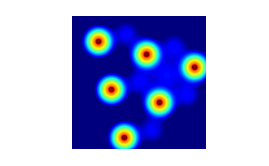

In [7]:
plot111cut()

In [18]:
o_orbitals = [AtomicWF('RCN/O/', 'O', weights = w).charge_density() for w in [[1., 0., 0.], [0., 1., 0.],
                                                              [0., 0., 1.]]]

In [ ]:
#mg_orbitals = [AtomicWF('../../Mg', 'Mg', weights = w) for w in [[1., 0., 0., 0.], [0., 1., 0., 0.],
#                                                              [0., 0., 1., 0.], [0., 0., 0., 1.]]];

Set up grid and charge distribution function:

In [11]:
r = np.arange(0.14, 10, .01);

In [16]:
r2 = np.arange(0., 10, .01);

<IPython.core.display.Javascript object>


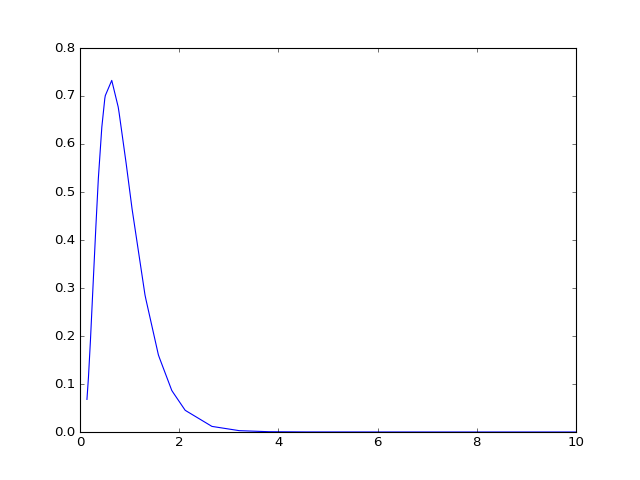

In [14]:
plt.plot(r, o_orbitals[2](r))

<IPython.core.display.Javascript object>


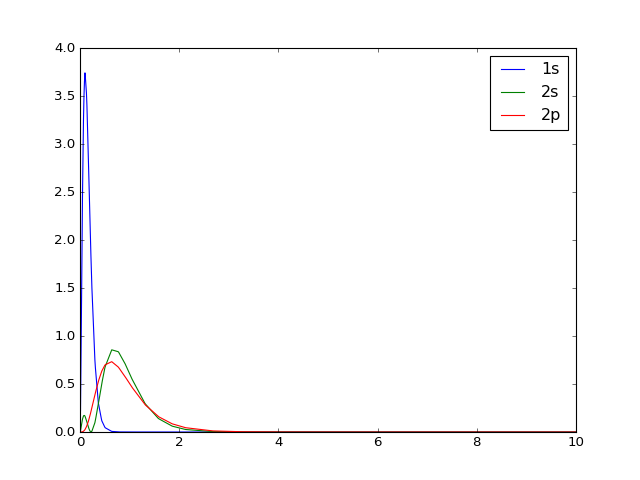

In [17]:
[plt.plot(r2, orb(r2), label = lab) for orb, lab in zip(o_orbitals, ['1s', '2s', '2p'])]
plt.legend()

<IPython.core.display.Javascript object>


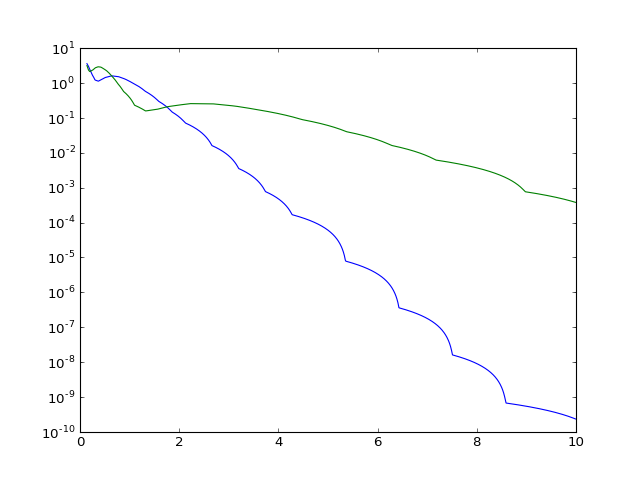

In [61]:
plt.semilogy()
plt.plot(r, ocdr(r))
plt.plot(r, mgcdr(r))

<IPython.core.display.Javascript object>


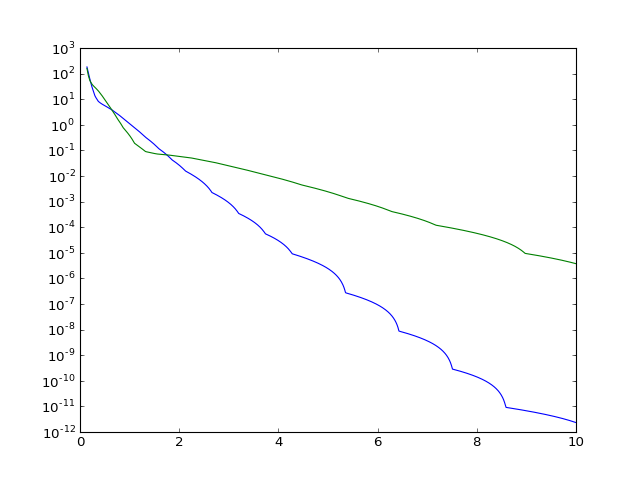

In [60]:
plt.semilogy()
plt.plot(r, ocd(r))
plt.plot(r, mgcd(r))

<IPython.core.display.Javascript object>


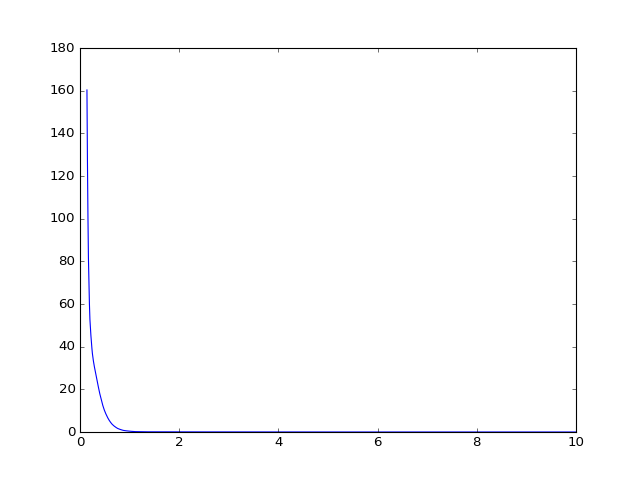

In [47]:
plt.plot(r, mgcd(r))

In [195]:
#test_density = test_cartesian(xyz)

Ionic MgO (no ionization)

<IPython.core.display.Javascript object>


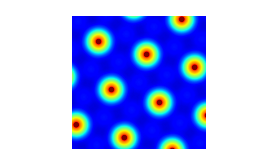

In [27]:
plot_cut(3., name = '111_Mg_no_ionization.png')

<IPython.core.display.Javascript object>


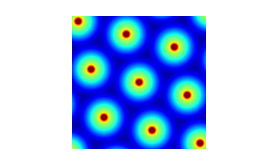

In [28]:
plot_cut(3.5, name = '111_O_no_ionization.png')

Ionized O:

<IPython.core.display.Javascript object>


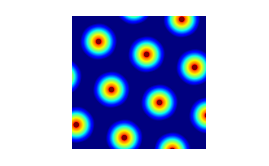

In [14]:
plot_cut(3., name = '111_Mg_ionized.png')

<IPython.core.display.Javascript object>


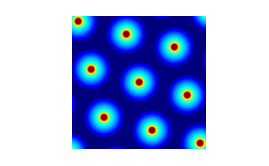

In [16]:
plot_cut(3.5, name = '111_O_ionized.png')

Atomic:

<IPython.core.display.Javascript object>


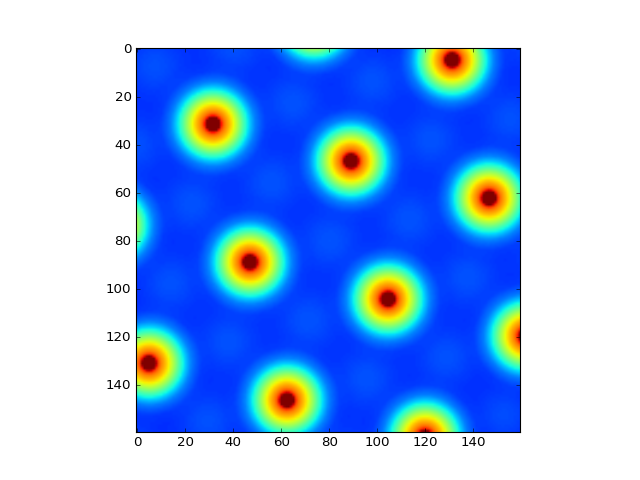

In [58]:
plot_cut(3.)

<IPython.core.display.Javascript object>


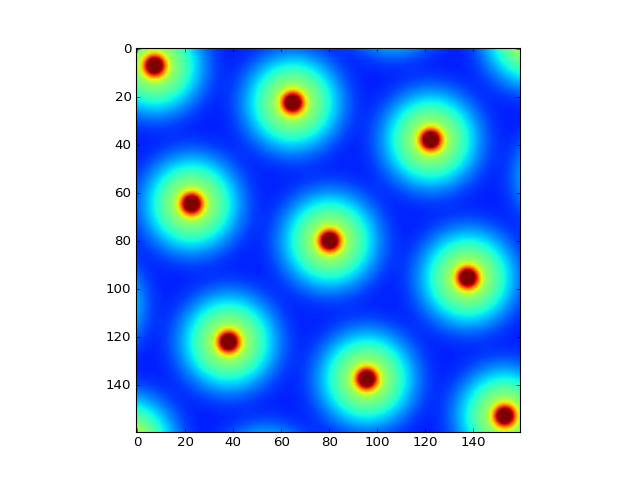

In [59]:
plot_cut(3.5)

In [4]:
mg = AtomicFF('Mg', weights = [1., 1., 1., 1.])

In [5]:
ff = mg.get_form_factor()

<IPython.core.display.Javascript object>


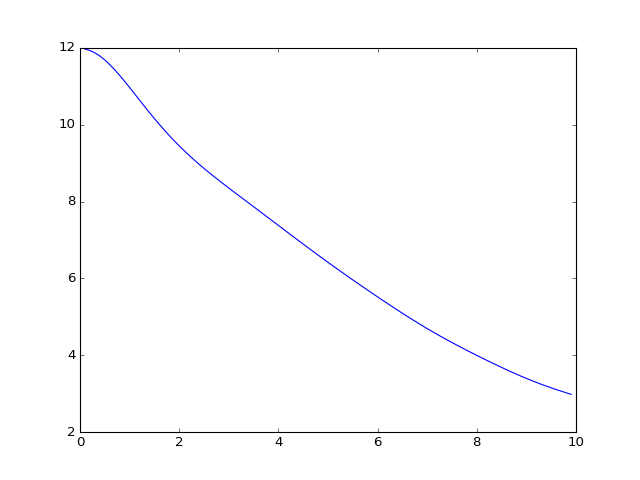

In [17]:
qq = np.arange(.1, 10, .1)
plt.plot(qq, [ff([q, 0, 0]) for q in qq])
plt.show()

In [13]:
o = AtomicFF('O', weights = [1., 1., 1.])

<IPython.core.display.Javascript object>


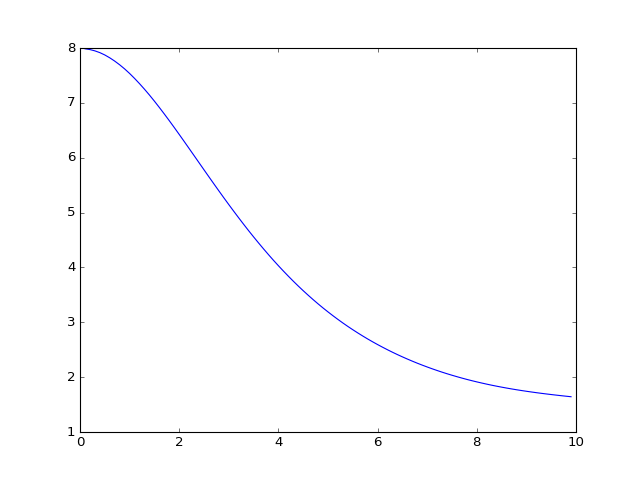

In [14]:
ff = o.get_form_factor()
qq = np.arange(.1, 10, .1)
plt.plot(qq, [ff([q, 0, 0]) for q in qq])
plt.show()

In [6]:
a = 4.212
A = np.array(
                [np.array([0.5, 0.5, 0.0]) * a,
                np.array([0.0, 0.5, 0.5]) * a,
                np.array([0.5, 0.0, 0.5]) * a]
    )
b = bgen(A)
v = [a * np.array([0., 0., 0.]), a * np.array([0.5, 0., 0.])]

In [5]:
hkl = get_hkl_sampler(['Mg', 'O'], v, None, b)

In [10]:
pks = list(map(np.array, [[1, 1, 1], [1, 1, 0], [2, 1, 1], [2, 2, 1], [2, 2, 2]]))

In [28]:
#bragg = list(map(hkl, pks))

In [27]:
sf = get_structure_factor(['Mg', 'O'], v, [[1., 1., 1., 0.], [1., 1., 0.]])

In [20]:
g2 = np.dot(np.array([1, 1, 0]), b)

In [13]:
g = np.dot(np.array([1, 1, 1]), b)

In [10]:
g

array([ 1.4917344,  1.4917344,  1.4917344])

In [23]:
np.linalg.norm(g)

2.5837597781114217

In [11]:
sf(g)

(3.1044793334960996-6.945456188089011e-16j)

In [26]:
sf(g2)

(14.618591134749011+0j)

In [14]:
sf(g)**2

(3.5751297989010191-3.1841464157631726e-15j)

In [19]:
sf(g)**2

(13.667849932629718-4.5903022392726466e-15j)

In [17]:
sf(g)**2

(30.285317086165055-4.398355952171633e-15j)

In [28]:
sf(g2)**2

(132.21778374664439+0j)

In [23]:
g = np.dot(np.array([1, 1, 0]), b)
sf(g)

(13.536105336967772+0j)

In [24]:
182.9/9.9

18.474747474747474

In [19]:
hkl(np.array([1, 1, 0]))

183.22614769348741

In [22]:
np.linalg.norm(sf(g))

3.1044793334960996

In [25]:
sf(np.array([1, 1, 1]) * b)

(9.9603720409373224-4.4052369141415306e-16j)